In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import seaborn as sns
import logging

import logging
import sys

def setup_logging(epoch_key, date_format='%d-%b-%y %H:%M:%S', format='%(asctime)s %(message)s'):
    animal, day, epoch = epoch_key
    log_filename = f"{animal}_{day:02d}_{epoch:02d}.log"

    logger = logging.getLogger()
    logger.setLevel(logging.INFO)
    formatter = logging.Formatter(fmt=format, datefmt=date_format)

    stdout_handler = logging.StreamHandler(sys.stdout)
    stdout_handler.setLevel(logging.INFO)
    stdout_handler.setFormatter(formatter)

    file_handler = logging.FileHandler(log_filename)
    file_handler.setLevel(logging.INFO)
    file_handler.setFormatter(formatter)

    logger.addHandler(file_handler)
    logger.addHandler(stdout_handler)

sns.set_context("talk")

In [3]:
epoch_key = 'Jaq', 3, 12

In [4]:
setup_logging(epoch_key)

In [5]:
from dask.distributed import Client

# for virga
client = Client(n_workers=28, threads_per_worker=2, processes=True)

client

Client Scheduler: tcp://127.0.0.1:45135 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 28 Cores: 56 Memory: 1.62 TB


In [6]:
from src.load_data import load_data


data = load_data(epoch_key,
                 position_to_linearize=['nose_x', 'nose_y'],
                 max_distance_from_well=5,
                 min_distance_traveled=30)

26-May-21 14:20:55 Loading position info...
26-May-21 14:21:33 Loading multiunit...
26-May-21 14:22:01 Loading spikes...
26-May-21 14:23:35 Finding ripple times...


In [7]:
continuous_transition_types = (
    [['random_walk', 'uniform'],
     ['uniform',     'uniform']])


classifier_parameters = {
    'movement_var': 6.0,
    'replay_speed': 1,
    'place_bin_size': 2.5,
    'continuous_transition_types': continuous_transition_types,
    'discrete_transition_diag': 0.968,
    'knot_spacing': 6,
    'spike_model_penalty': 0.5,
    'position_range': ((data['position_info'].nose_x.min(), data['position_info'].nose_x.max()),
                       (data['position_info'].nose_y.min(), data['position_info'].nose_y.max()))
}

In [ ]:
from replay_trajectory_classification import SortedSpikesClassifier
from src.parameters import PROCESSED_DATA_DIR

from sklearn.model_selection import KFold
import os

state_names = ['Continuous', 'Fragmented']
cv = KFold()
results = []

for fold_ind, (train, test) in enumerate(cv.split(data["position_info"].index)):
    logging.info(f'Fitting Fold #{fold_ind + 1}...')
    classifier = SortedSpikesClassifier(**classifier_parameters)
    classifier.fit(
        position=data["position_info"].iloc[train].loc[:, ['nose_x', 'nose_y']],
        spikes=data["spikes"].iloc[train],
    )
    classifier.save_model(
        os.path.join(PROCESSED_DATA_DIR,
            f"{epoch_key[0]}_{epoch_key[1]:02d}_{epoch_key[2]:02d}_"
            f"sortedspikes_2D_{fold_ind}_model.pkl")
    )

    logging.info('Predicting posterior...')
    results.append(
        classifier.predict(
            data["spikes"].iloc[test],
            time=data["position_info"].iloc[test].index / np.timedelta64(1, "s"),
            state_names=state_names
        )
    )
    
# concatenate results 
results = xr.concat(
    results, dim="time"
)

# save the results as .nc format. ncread matlab can read these
results.to_netcdf(
    os.path.join(PROCESSED_DATA_DIR,
   f"{epoch_key[0]}_{epoch_key[1]:02d}_{epoch_key[2]:02d}_sortedspikes_2D_results.nc")
)
logging.info('Done...\n\n')

26-May-21 14:24:30 Fitting Fold #1...
26-May-21 14:24:30 Fitting initial conditions...
26-May-21 14:24:31 Fitting state transition...
26-May-21 14:24:33 Fitting place fields...


In [ ]:
client.close()

In [12]:
results

<xarray.Dataset>
Dimensions:            (state: 2, time: 451893, x_position: 48, y_position: 48)
Coordinates:
  * time               (time) float64 1.636e+04 1.636e+04 ... 1.727e+04
  * x_position         (x_position) float64 1.25 3.75 6.25 ... 113.7 116.2 118.7
  * y_position         (y_position) float64 1.249 3.747 6.245 ... 116.1 118.6
  * state              (state) <U10 'Continuous' 'Fragmented'
Data variables:
    likelihood         (time, state, x_position, y_position) float64 0.0 ... nan
    causal_posterior   (time, state, x_position, y_position) float64 0.0 ... nan
    acausal_posterior  (time, state, x_position, y_position) float64 0.0 ... nan

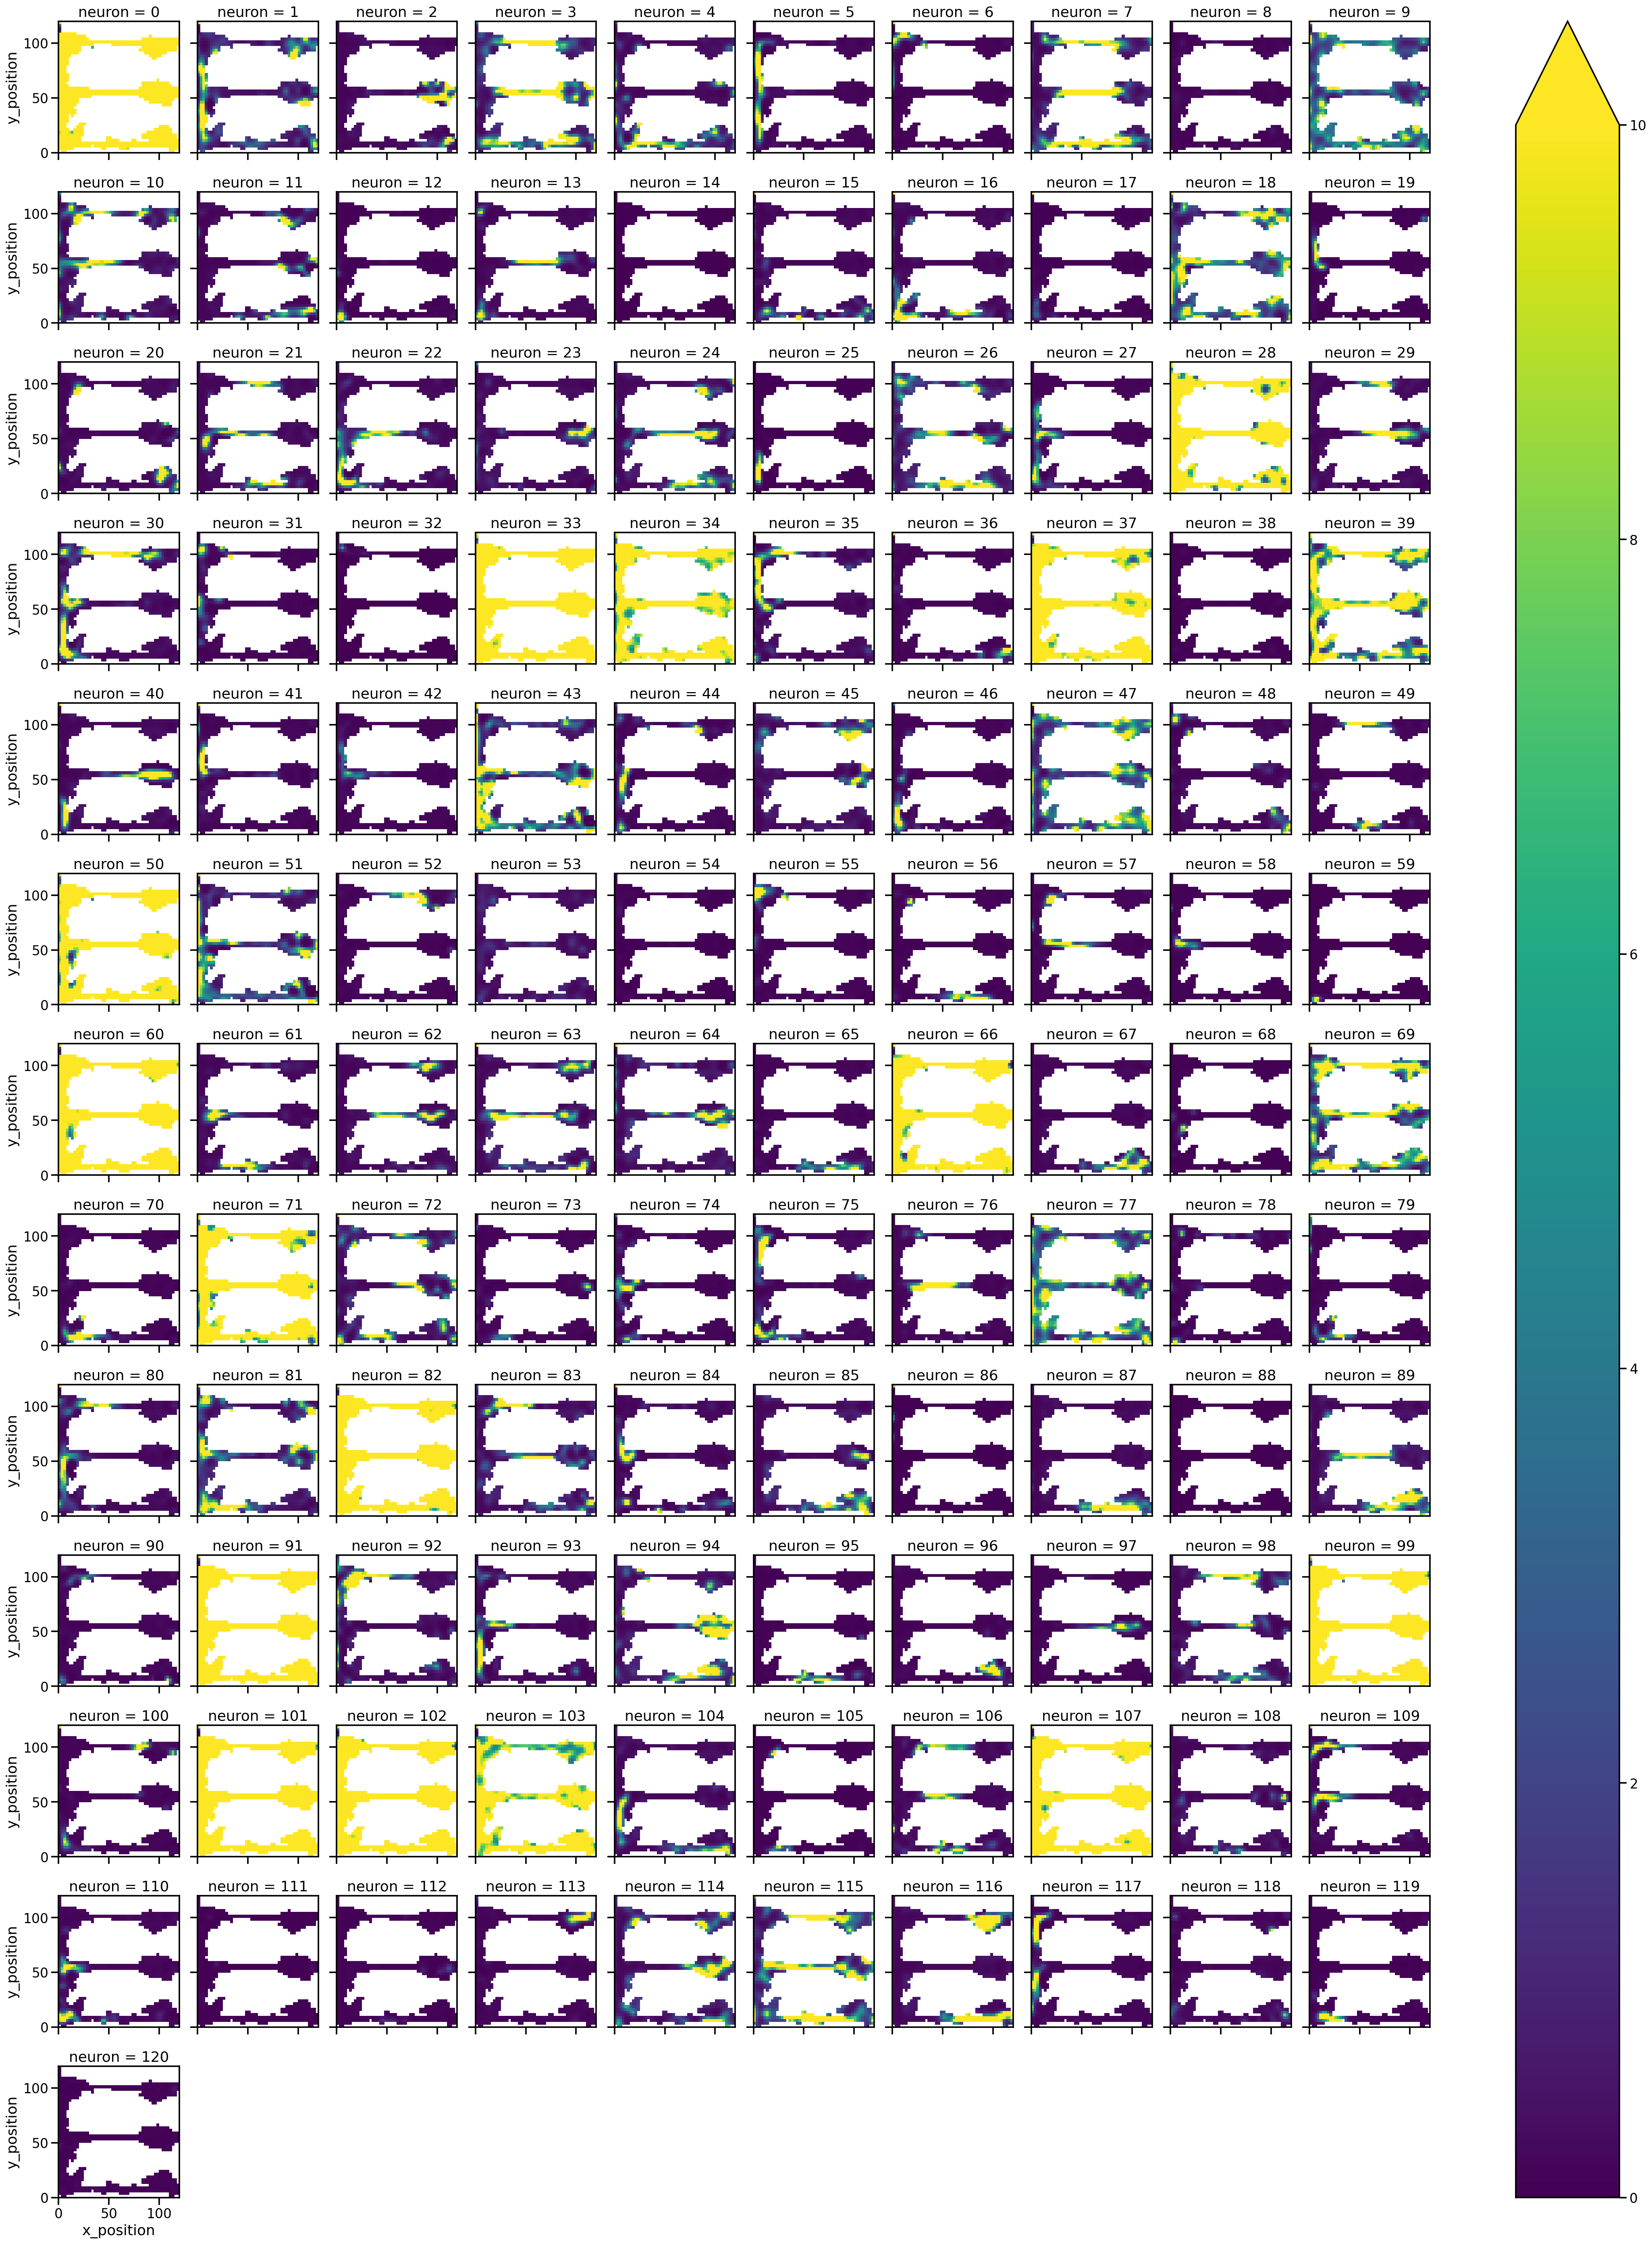

In [11]:
g = (classifier.place_fields_.isel(encoding_group=0).unstack('position').where(classifier.is_track_interior_[np.newaxis, ...]) * 500).plot(
        x='x_position', y='y_position', col='neuron', col_wrap=10, vmin=0.0, vmax=10.0)

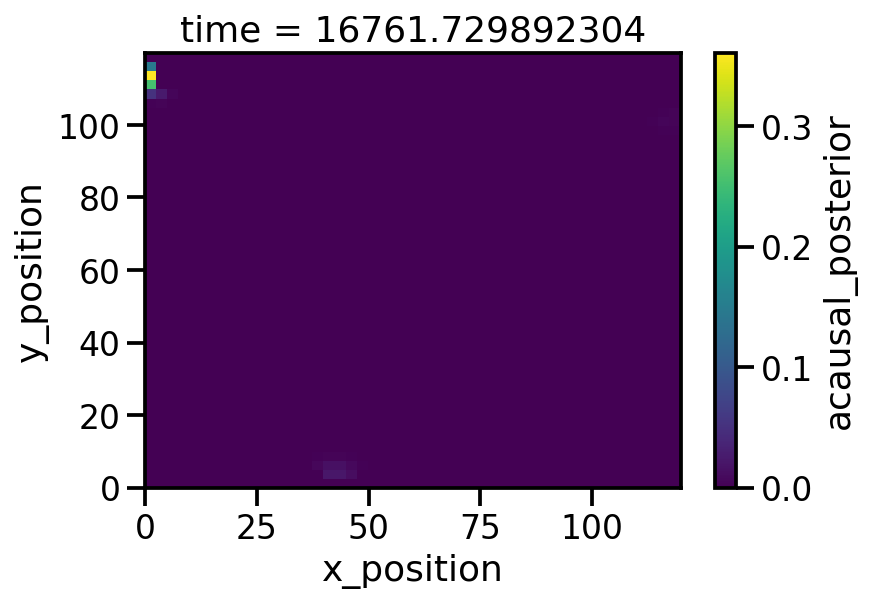

In [15]:
results.acausal_posterior.isel(time=200_000).sum('state').plot(x='x_position', y='y_position')

In [22]:
results2 = results.assign_coords(time=data['position_info'].index)

In [ ]:
from src.visualization import make_2D_classifier_movie

time_slice = results2.time[slice(422_000, 431_000)]

make_2D_classifier_movie(
    classifier,
    results2,
    time_slice,
    data,
    movie_name="test_2D_classifier_movie.mp4",
)

02-Jun-21 13:33:31 Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
02-Jun-21 13:33:31 MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 864x576 -pix_fmt rgba -r 16 -loglevel error -i pipe: -vcodec h264 -pix_fmt yuv420p -b 1800k -metadata artist=Me -y test_2D_classifier_movie.mp4
